In [1]:
# Import modules

from __future__ import print_function
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
from six.moves import range

%matplotlib inline

In [2]:
# Load training and test file
flank_len = 9

train_file = 'train_f' + str(flank_len) + '.pickle'

with open(train_file, 'rb') as train:
    save = pickle.load(train)
    dataset = save['seq']  # data type : numpy.ndarray // 'list' can't be dealt with 'shape' and 'reshape' 
    labels = save['label']

    del save

test_file = 'test_f' + str(flank_len) + '.pickle'

with open(test_file, 'rb') as test:
    save = pickle.load(test)
    test_dataset = save['seq']
  
    del save

In [3]:
# Determine how many folds
fold = 4
num = int(dataset.shape[0])
        
# Split data into several parts
dataset_array = np.split(dataset, np.arange(int(np.ceil(num/fold)), num, int(np.ceil(num/fold))), axis = 0)
labels_array = np.split(labels, np.arange(int(np.ceil(num/fold)), num, int(np.ceil(num/fold))), axis = 0)

train_dataset = np.empty([1, 101+(2*flank_len), 4])
train_labels = np.empty([1,2])
for i in range(0, fold):
    if i == 0:  # (i+1)th partition
        valid_dataset = dataset_array[i]
        valid_labels = labels_array[i]
    else:
        train_dataset = np.concatenate((train_dataset, dataset_array[i]), axis = 0)
        train_labels = np.concatenate((train_labels, labels_array[i]), axis = 0)
train_dataset = np.delete(train_dataset,0,0)
train_labels = np.delete(train_labels,0,0)
print('training set', train_dataset.shape, train_labels.shape)
print('validation set', valid_dataset.shape, valid_labels.shape)
print('test set', test_dataset.shape)

training set (58148, 119, 4) (58148, 2)
validation set (19383, 119, 4) (19383, 2)
test set (19383, 119, 4)


In [4]:
dataset_row = train_dataset.shape[1]
dataset_column = train_dataset.shape[2]
num_channels = 1

def reformat(dataset, labels):
    dataset = dataset.reshape(
        (-1, dataset_row, dataset_column, num_channels)).astype(np.float32)
    return dataset, labels
def test_reformat(dataset):
    dataset = dataset.reshape(
        (-1, dataset_row, dataset_column, num_channels)).astype(np.float32)
    return dataset

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset = test_reformat(test_dataset)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape)

Training set (58148, 119, 4, 1) (58148, 2)
Validation set (19383, 119, 4, 1) (19383, 2)
Test set (19383, 119, 4, 1)


In [5]:
num_labels = 2
batch_size = 256
depth = 16
num_hidden = 128
num_hidden2 = 64
beta_regul = 5e-4
stride_1 = 2
stride_2 = 2

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, dataset_row, dataset_column, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
        [21, 4, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
        [9, 2, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
        [math.ceil(math.ceil(train_dataset.shape[1]/stride_1)/stride_1)*depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_hidden2], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))
    layer5_weights = tf.Variable(tf.truncated_normal(
        [num_hidden2, num_labels], stddev=0.1))
    layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, stride_1, stride_1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, stride_2, stride_2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        drop = tf.nn.dropout(hidden, 0.7)
        hidden = tf.nn.relu(tf.matmul(drop, layer4_weights) + layer4_biases)
        drop = tf.nn.dropout(hidden, 0.7)
        return tf.matmul(drop, layer5_weights) + layer5_biases
  
  # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits, tf_train_labels) + \
        beta_regul *(
            1 * tf.nn.l2_loss(layer3_weights) + \
            1 * tf.nn.l2_loss(layer4_weights) + \
            1 * tf.nn.l2_loss(layer5_weights)))
     
  # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.25, global_step, 6000, 0.88)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.sigmoid(logits)
    valid_prediction = tf.sigmoid(model(tf_valid_dataset))
    test_prediction = tf.sigmoid(model(tf_test_dataset))

	 minibatch	 minibatch	 validation
Steps	 loss     	 accuracy 	 accuracy
---------------------------------------------------
0	 1.573298	 47.266 %	 49.337 %	
500	 0.789611	 57.031 %	 60.610 %	
1000	 0.618249	 74.609 %	 72.858 %	
1500	 0.538275	 78.516 %	 77.651 %	
2000	 0.525321	 82.422 %	 82.216 %	
2500	 0.452186	 82.812 %	 83.434 %	
3000	 0.373034	 87.109 %	 87.056 %	
3500	 0.355203	 89.844 %	 87.546 %	
4000	 0.355099	 89.844 %	 87.437 %	
4500	 0.410359	 86.719 %	 87.484 %	
5000	 0.281168	 91.016 %	 89.212 %	
5500	 0.282837	 91.406 %	 89.274 %	
6000	 0.357626	 86.719 %	 86.416 %	
6500	 0.244438	 93.359 %	 89.677 %	
7000	 0.261607	 90.234 %	 86.973 %	
7500	 0.188995	 94.922 %	 89.883 %	
8000	 0.231573	 91.016 %	 89.548 %	
8500	 0.181226	 94.531 %	 89.130 %	
9000	 0.251837	 92.188 %	 89.677 %	
9500	 0.245221	 91.406 %	 88.268 %	
10000	 0.247332	 91.797 %	 89.026 %	


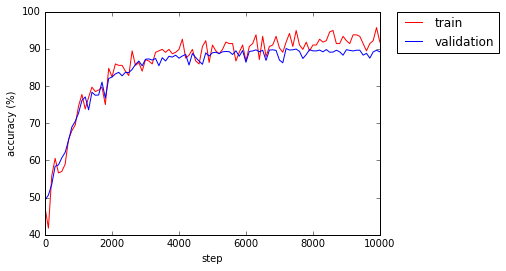

test accuracy : 89.006 %


In [6]:
num_steps = 10001
interval = 100
y = []
z = []

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(graph=graph, config=config) as session:
    tf.initialize_all_variables().run()
    print('\t', 'minibatch\t', 'minibatch\t', 'validation')
    print('Steps\t', 'loss     \t', 'accuracy \t', 'accuracy')
    print('---------------------------------------------------')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('%d\t %f\t %.3f %%\t %.3f %%\t' % (
                step,
                l,
                accuracy(predictions, batch_labels),
                accuracy(valid_prediction.eval(), valid_labels)
                ))
        if (step % interval == 0):
            y.append(accuracy(predictions, batch_labels))
            z.append(accuracy(valid_prediction.eval(), valid_labels))
    
    x = np.arange(0, num_steps, interval)
    plt.plot(x, y, 'r', label='train')
    plt.plot(x, z, 'b', label='validation')
    plt.xlabel("step")
    plt.ylabel("accuracy (%)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()
    
    # Prediction

    with open('test_ans.data.txt', 'r') as f:
        i = 0
        count = 0
        result = np.argmax(test_prediction.eval(), 1)
        for line in f:
            ans = line.split(" ")[-1].split("\n")[0]
            if result[i] == int(ans):
                count += 1
            i += 1
    print("test accuracy : %.3f %%"%(100*count/len(result)))